In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "LBD"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn005241,MKEINGRKQGVASPCAACKLLRRRCAEDCVFAPYFPADEPQKFASV...,182,1
1,Achn008351,MSDTHLLRPTCRHVGAEQVHKLNFACKFLRRKCLPGCIFAPYFPPE...,183,1
2,Achn012881,MSCNGCRVLRKGCSENCILRPSLQWIDSPEAQGHATVFVAKFFGRA...,224,1
3,Achn019011,MGGNSPCASCKLLRRRCAKDCIFAPYFPSDDPQKFAMVHKVFGASN...,168,1
4,Achn028271,MSSSNSPCAACKFLRRKCTQECVFAPYFPPDQPQKFSNVHKVFGAS...,294,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
13623,0.021978,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2803,0.048673,0.004425,0.008850,0.000000,0.0,0.004425,0.004425,0.000000,0.004425,0.000000,...,0.000000,0.0,0.004425,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
8711,0.005831,0.002915,0.011662,0.005831,0.0,0.002915,0.000000,0.002915,0.000000,0.005831,...,0.002915,0.0,0.002915,0.0,0.000000,0.0,0.005831,0.0,0.0,0.0
10302,0.003030,0.003030,0.003030,0.006061,0.0,0.000000,0.000000,0.006061,0.003030,0.009091,...,0.000000,0.0,0.003030,0.0,0.006061,0.0,0.003030,0.0,0.0,0.0
8275,0.019802,0.000000,0.000000,0.003300,0.0,0.006601,0.009901,0.006601,0.009901,0.003300,...,0.003300,0.0,0.000000,0.0,0.000000,0.0,0.003300,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (11523, 441)
X_test: (2881, 441)
y_train: (11523,)
y_test: (2881,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1:33 653ms/step - accuracy: 0.3750 - loss: 0.6932

 27/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6277 - loss: 0.6841    

 53/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7111 - loss: 0.6386

 80/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7597 - loss: 0.5719

108/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7927 - loss: 0.5121

135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8153 - loss: 0.4669

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8228 - loss: 0.4511 - val_accuracy: 0.9818 - val_loss: 0.0563


Epoch 2/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0166

 27/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0571 

 54/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.0617

 81/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9794 - loss: 0.0621

107/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9794 - loss: 0.0612

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9795 - loss: 0.0601

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9797 - loss: 0.0596 - val_accuracy: 0.9848 - val_loss: 0.0486


Epoch 3/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0204

 26/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0337 

 53/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0373

 80/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.0382

107/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0385

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0389

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0392 - val_accuracy: 0.9831 - val_loss: 0.0488


Epoch 4/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0270

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0443 

 55/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0459

 81/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0459

108/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0455

135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0455

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0456 - val_accuracy: 0.9826 - val_loss: 0.0561


Epoch 5/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0187

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9793 - loss: 0.0627 

 55/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.0542

 83/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0505

109/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0487

136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0475

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.0471 - val_accuracy: 0.9818 - val_loss: 0.0607


Epoch 6/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0670

 27/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0332 

 54/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0284

 80/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0281

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0295

133/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0308

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0312 - val_accuracy: 0.9826 - val_loss: 0.0580


Epoch 7/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0214

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0198 

 56/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0239

 83/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0261

110/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0287

137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0307

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0313 - val_accuracy: 0.9848 - val_loss: 0.0505


Epoch 8/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0374

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0339 

 56/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0350

 84/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0345

111/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0336

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0330

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0329 - val_accuracy: 0.9796 - val_loss: 0.0738


Epoch 9/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0179

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0149 

 55/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0198

 82/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0200

109/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0203

137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0209

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0211 - val_accuracy: 0.9822 - val_loss: 0.0631


Epoch 10/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9844 - loss: 0.0659

 27/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0285 

 54/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0279

 81/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0271

108/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0263

135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0258

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0257 - val_accuracy: 0.9818 - val_loss: 0.0672


Epoch 11/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0020

 27/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0349 

 53/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0289

 80/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0278

107/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0266

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0258

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0256 - val_accuracy: 0.9822 - val_loss: 0.0694


Epoch 12/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0058

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0198 

 55/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0259

 81/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0280

107/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0295

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0297

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0298 - val_accuracy: 0.9852 - val_loss: 0.0550


Epoch 13/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0057

 26/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.0774 

 52/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9769 - loss: 0.0748

 77/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.0686

102/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0642

128/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0605

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.0582 - val_accuracy: 0.9835 - val_loss: 0.0627


Epoch 14/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0334

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0171 

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0181

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0182

112/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0182

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0182

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0182 - val_accuracy: 0.9835 - val_loss: 0.0648


Epoch 15/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0679

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0262 

 56/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0216

 83/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0200

101/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0194

126/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0187

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0186 - val_accuracy: 0.9835 - val_loss: 0.0673


Epoch 16/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0028

 25/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0352 

 51/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0286

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0252

104/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0235

130/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0223

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0217 - val_accuracy: 0.9822 - val_loss: 0.0675


Epoch 17/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0196

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0199 

 54/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0189

 80/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0179

107/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0171

133/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0166

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0164 - val_accuracy: 0.9826 - val_loss: 0.0696


Epoch 18/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.0468e-04

 27/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0069     

 54/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0092

 81/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0095

108/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0104

135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0112

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0115 - val_accuracy: 0.9826 - val_loss: 0.0612


Epoch 19/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0331

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0128 

 55/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0135

 83/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0134

109/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0128

136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0127

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0128 - val_accuracy: 0.9818 - val_loss: 0.0636


Epoch 20/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0018

 27/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0191 

 54/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0179

 81/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0165

109/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0155

136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0147

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0145 - val_accuracy: 0.9826 - val_loss: 0.0711


Epoch 21/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 9.0140e-04

 27/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0037     

 54/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0051

 80/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0059

107/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0067

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0073

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0075 - val_accuracy: 0.9757 - val_loss: 0.1023


Epoch 22/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0439

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0165 

 55/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0157

 82/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0149

109/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0142

137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0137

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0136 - val_accuracy: 0.9831 - val_loss: 0.0697



[Train Accuracy: 99.54% - Test Accuracy: 98.02%]


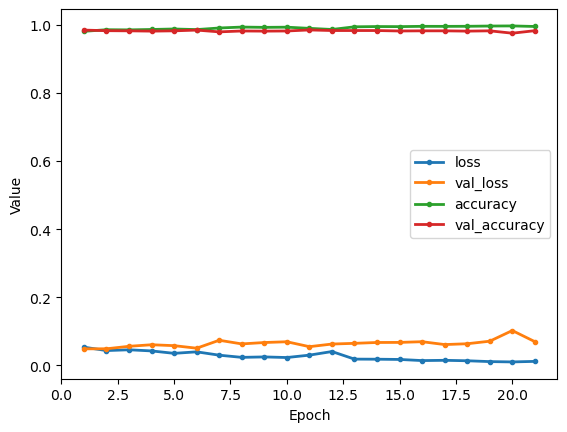

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


 1/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
13623,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2803,0.031111,0.004444,0.0,0.0,0.0,0.004444,0.004444,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8711,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10302,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00304,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8275,0.000000,0.000000,0.0,0.0,0.0,0.003311,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (11523, 8996)
X_test: (2881, 8996)
y_train: (11523,)
y_test: (2881,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,303,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,346,497 (8.95 MB)

 Trainable params: 2,346,497 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2:08 895ms/step - accuracy: 0.5625 - loss: 0.6931

  7/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5124 - loss: 0.6929   

 13/145 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5473 - loss: 0.6922 

 20/145 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5967 - loss: 0.6902

 27/145 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6379 - loss: 0.6869

 34/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6701 - loss: 0.6812

 41/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6966 - loss: 0.6718

 48/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7185 - loss: 0.6585

 55/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7368 - loss: 0.6420

 62/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7525 - loss: 0.6236

 69/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7662 - loss: 0.6044

 76/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7783 - loss: 0.5853

 83/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7890 - loss: 0.5667

 90/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7986 - loss: 0.5491

 97/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8072 - loss: 0.5324

104/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8149 - loss: 0.5167

111/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8220 - loss: 0.5020

118/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8285 - loss: 0.4881

125/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8344 - loss: 0.4750

132/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8398 - loss: 0.4626

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8449 - loss: 0.4508

145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8496 - loss: 0.4398 - val_accuracy: 0.9931 - val_loss: 0.0183


Epoch 2/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 0.0058

  8/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0044 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9995 - loss: 0.0053

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9990 - loss: 0.0065

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9986 - loss: 0.0074

 36/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9985 - loss: 0.0078

 43/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9985 - loss: 0.0079

 50/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9984 - loss: 0.0082

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9983 - loss: 0.0085

 64/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0087

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9981 - loss: 0.0088

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9980 - loss: 0.0090

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9979 - loss: 0.0092

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9978 - loss: 0.0093

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9978 - loss: 0.0095

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0095

113/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0096

120/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0097

127/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0097

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0097

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0098

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9976 - loss: 0.0098 - val_accuracy: 0.9948 - val_loss: 0.0153


Epoch 3/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 0.0021

  7/145 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0012 

 14/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 0.0011

 21/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0013

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0013

 35/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0013

 42/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0013

 49/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0013

 56/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0014

 63/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0014

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0015

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0016

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0016

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0016

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0017

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0017

113/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0017

120/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0017

127/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0017

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0017

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0017

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9961 - val_loss: 0.0134


Epoch 4/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 0.0031

  7/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0013 

 14/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.3447e-04

 21/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 8.7401e-04

 28/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 9.1120e-04

 35/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 9.1815e-04

 42/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 9.1753e-04

 49/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 9.1732e-04

 56/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 9.0694e-04

 63/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 9.0199e-04

 70/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 9.4079e-04

 77/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 9.6677e-04

 84/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 9.9143e-04

 91/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010    

 98/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010

105/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010

112/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010

119/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010

126/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010

133/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9944 - val_loss: 0.0180


Epoch 5/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 2.7946e-04

  8/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3320e-04 

 16/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8380e-04

 23/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9171e-04

 30/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3413e-04

 37/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5282e-04

 44/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6383e-04

 51/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7228e-04

 58/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7473e-04

 65/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7254e-04

 72/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6811e-04

 79/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6189e-04

 86/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5467e-04

 93/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4717e-04

100/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3985e-04

107/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3256e-04

114/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2524e-04

121/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1808e-04

128/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1106e-04

135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0434e-04

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9782e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.9421e-04 - val_accuracy: 0.9922 - val_loss: 0.0335


Epoch 6/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 9.7311e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2158e-04 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1950e-04

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2188e-04

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2107e-04

 36/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1892e-04

 43/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1619e-04

 50/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1344e-04

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1102e-04

 64/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0914e-04

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0731e-04

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0550e-04

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0422e-04

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1884e-04

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5646e-04

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 2.1190e-04

113/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 2.7369e-04

120/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 3.3348e-04

127/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 3.8364e-04

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 4.2540e-04

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 4.6067e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 4.8269e-04 - val_accuracy: 0.9926 - val_loss: 0.0392


Epoch 7/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 2.6906e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.2619e-04 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.2006e-04

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1230e-04

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0639e-04

 36/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0163e-04

 43/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8543e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6992e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7118e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6865e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8108e-05

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0001e-04

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0259e-04

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0524e-04

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0730e-04

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0889e-04

113/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0998e-04

120/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1071e-04

127/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1121e-04

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1149e-04

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1156e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1171e-04 - val_accuracy: 0.9944 - val_loss: 0.0310


Epoch 8/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 1.8513e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.6174e-04 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6004e-04

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7678e-04

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7030e-04

 36/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6280e-04

 43/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5267e-04

 50/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4205e-04

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3188e-04

 64/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2245e-04

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1441e-04

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0686e-04

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0001e-04

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9423e-04

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8883e-04

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8377e-04

113/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7898e-04

120/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7452e-04

128/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6971e-04

136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6523e-04

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6155e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.6006e-04 - val_accuracy: 0.9939 - val_loss: 0.0355


Epoch 9/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 1.5797e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7791e-05 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8649e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8464e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8750e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8912e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8875e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2274e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6731e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0162e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3089e-05

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6542e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9408e-05

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1513e-05

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3071e-05

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4227e-05

109/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.4615e-05

116/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5333e-05

123/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5835e-05

130/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.6148e-05

137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.6315e-05

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.6400e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.6413e-05 - val_accuracy: 0.9935 - val_loss: 0.0397


Epoch 10/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 2.6972e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3387e-05 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2319e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1850e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2453e-05

 37/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2907e-05

 44/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4508e-05

 51/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5583e-05

 58/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6272e-05

 65/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6677e-05

 72/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6999e-05

 79/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7187e-05

 86/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7332e-05

 93/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7438e-05

100/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7573e-05

107/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7676e-05

114/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7740e-05

121/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7789e-05

128/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7833e-05

135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7860e-05

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7853e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.7839e-05 - val_accuracy: 0.9944 - val_loss: 0.0371


Epoch 11/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 9.8251e-06

  8/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.6189e-06 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0963e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1411e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1542e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1692e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1693e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1698e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1844e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1860e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1831e-05

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1811e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1761e-05

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1745e-05

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1743e-05

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1717e-05

113/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1685e-05

121/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1633e-05

128/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1577e-05

135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1531e-05

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1487e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1461e-05 - val_accuracy: 0.9944 - val_loss: 0.0377


Epoch 12/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 9.0934e-06

  8/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.2184e-05 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0950e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0598e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0453e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0483e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0326e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0360e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0293e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0202e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0106e-05

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0022e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.9261e-06

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8759e-06

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8334e-06

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8238e-06

113/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8227e-06

120/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8077e-06

127/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7830e-06

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7562e-06

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7352e-06

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.7226e-06 - val_accuracy: 0.9935 - val_loss: 0.0405


Epoch 13/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 3.4791e-06

  8/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.8744e-05 

 15/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1880e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0861e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9818e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8777e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8091e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7879e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7516e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7193e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7040e-05

 78/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6887e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6684e-05

 92/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6491e-05

 99/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6369e-05

106/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6237e-05

113/145 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6097e-05

120/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5955e-05

127/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5813e-05

134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5663e-05

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5506e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.5397e-05 - val_accuracy: 0.9944 - val_loss: 0.0391



[Train Accuracy: 100.00% - Test Accuracy: 99.17%]


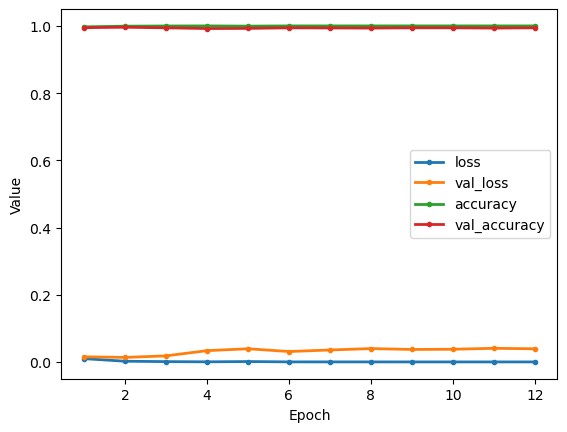

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/91 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

46/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

44/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
13623,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2803,0.026786,0.0,0.0,0.0,0.0,0.0,0.004464,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8711,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10302,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8275,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      40,194,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,235,521 (153.49 MB)

 Trainable params: 40,235,521 (153.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 2:09 900ms/step - accuracy: 0.4688 - loss: 0.6932

  2/145 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.4844 - loss: 0.6931 

  3/145 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.4878 - loss: 0.6931

  4/145 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.4948 - loss: 0.6930

  5/145 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.4933 - loss: 0.6930

  6/145 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.4910 - loss: 0.6930

  7/145 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.4926 - loss: 0.6930

  8/145 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.4979 - loss: 0.6929

  9/145 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.5037 - loss: 0.6929

 10/145 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.5109 - loss: 0.6928

 11/145 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.5174 - loss: 0.6926

 12/145 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.5241 - loss: 0.6925

 13/145 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.5292 - loss: 0.6923

 14/145 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.5346 - loss: 0.6921

 15/145 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.5397 - loss: 0.6919

 16/145 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.5445 - loss: 0.6917

 17/145 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.5491 - loss: 0.6915

 18/145 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.5540 - loss: 0.6912

 19/145 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.5588 - loss: 0.6910

 20/145 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.5636 - loss: 0.6907

 21/145 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.5687 - loss: 0.6904

 22/145 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5737 - loss: 0.6901

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.5788 - loss: 0.6898

 24/145 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.5839 - loss: 0.6894

 25/145 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.5887 - loss: 0.6890

 26/145 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.5935 - loss: 0.6886

 27/145 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5981 - loss: 0.6881

 28/145 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.6027 - loss: 0.6876

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.6071 - loss: 0.6871

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.6114 - loss: 0.6865

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.6156 - loss: 0.6859

 32/145 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.6197 - loss: 0.6852

 33/145 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.6237 - loss: 0.6845

 34/145 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.6276 - loss: 0.6837

 35/145 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.6314 - loss: 0.6829

 36/145 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.6351 - loss: 0.6821

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.6387 - loss: 0.6812

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.6423 - loss: 0.6802

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.6457 - loss: 0.6792

 40/145 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.6490 - loss: 0.6782

 41/145 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.6523 - loss: 0.6771

 42/145 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.6555 - loss: 0.6759

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.6586 - loss: 0.6747

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.6616 - loss: 0.6735

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.6646 - loss: 0.6721

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.6675 - loss: 0.6707

 47/145 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.6704 - loss: 0.6693

 48/145 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.6732 - loss: 0.6678

 49/145 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.6760 - loss: 0.6661

 50/145 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.6788 - loss: 0.6645

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.6815 - loss: 0.6628

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.6841 - loss: 0.6610

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.6867 - loss: 0.6591

 54/145 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.6892 - loss: 0.6573

 55/145 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.6917 - loss: 0.6553

 56/145 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.6942 - loss: 0.6533

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.6966 - loss: 0.6513

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.6990 - loss: 0.6492

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.7013 - loss: 0.6471

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.7036 - loss: 0.6449

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.7059 - loss: 0.6427

 62/145 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.7081 - loss: 0.6405

 63/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.7102 - loss: 0.6382

 64/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.7124 - loss: 0.6360

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.7144 - loss: 0.6336

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7165 - loss: 0.6313

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7185 - loss: 0.6289

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7205 - loss: 0.6266

 69/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7225 - loss: 0.6242

 70/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7245 - loss: 0.6218

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7264 - loss: 0.6193

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7283 - loss: 0.6169

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7301 - loss: 0.6145

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7319 - loss: 0.6120

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7337 - loss: 0.6096

 76/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7355 - loss: 0.6072

 77/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7373 - loss: 0.6047 

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7390 - loss: 0.6023

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7407 - loss: 0.5998

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7424 - loss: 0.5974

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7440 - loss: 0.5949

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7456 - loss: 0.5925

 83/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7472 - loss: 0.5901

 84/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.7488 - loss: 0.5877

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.7504 - loss: 0.5853

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.7519 - loss: 0.5829

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.7534 - loss: 0.5805

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.7549 - loss: 0.5782

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.7564 - loss: 0.5758

 90/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.7578 - loss: 0.5735

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7593 - loss: 0.5712

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7607 - loss: 0.5689

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7621 - loss: 0.5665

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7635 - loss: 0.5643

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7648 - loss: 0.5620

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7662 - loss: 0.5597

 97/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7675 - loss: 0.5575

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7688 - loss: 0.5552

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.7701 - loss: 0.5530

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7714 - loss: 0.5508

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7726 - loss: 0.5486

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7739 - loss: 0.5464

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7751 - loss: 0.5443

104/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7763 - loss: 0.5421

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7775 - loss: 0.5400

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7787 - loss: 0.5378

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7798 - loss: 0.5357

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7810 - loss: 0.5337

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7821 - loss: 0.5316

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7833 - loss: 0.5295

111/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7844 - loss: 0.5275

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7855 - loss: 0.5255

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7866 - loss: 0.5234

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7876 - loss: 0.5214

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7887 - loss: 0.5195

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7898 - loss: 0.5175

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7908 - loss: 0.5155

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7918 - loss: 0.5136

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7928 - loss: 0.5117

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7939 - loss: 0.5097

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7948 - loss: 0.5078

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7958 - loss: 0.5059

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7968 - loss: 0.5041

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7978 - loss: 0.5022

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7987 - loss: 0.5004

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7997 - loss: 0.4985

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8006 - loss: 0.4967

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8015 - loss: 0.4949

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8024 - loss: 0.4931

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8033 - loss: 0.4914

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8042 - loss: 0.4896

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8051 - loss: 0.4878

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8060 - loss: 0.4861

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8068 - loss: 0.4844

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8077 - loss: 0.4827

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8085 - loss: 0.4810

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8094 - loss: 0.4793

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8102 - loss: 0.4776

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8110 - loss: 0.4759

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8119 - loss: 0.4743

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8127 - loss: 0.4726

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8135 - loss: 0.4710

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8143 - loss: 0.4694

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8150 - loss: 0.4678

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8158 - loss: 0.4662

145/145 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step - accuracy: 0.8166 - loss: 0.4646 - val_accuracy: 0.9970 - val_loss: 0.0150


Epoch 2/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 43s 299ms/step - accuracy: 1.0000 - loss: 0.0024

  2/145 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 1.0000 - loss: 0.0031

  3/145 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 0.0035

  4/145 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 0.0038

  5/145 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 1.0000 - loss: 0.0040

  6/145 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 0.0041

  7/145 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 0.0041

  8/145 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 0.0042

  9/145 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9998 - loss: 0.0045

 10/145 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9997 - loss: 0.0047

 11/145 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.9996 - loss: 0.0048

 12/145 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.9995 - loss: 0.0049

 13/145 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.9994 - loss: 0.0050

 14/145 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.9994 - loss: 0.0050

 15/145 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.9994 - loss: 0.0051

 16/145 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.9994 - loss: 0.0051

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9993 - loss: 0.0051

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.9993 - loss: 0.0051

 19/145 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9993 - loss: 0.0051

 20/145 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9993 - loss: 0.0052

 21/145 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9993 - loss: 0.0052

 22/145 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9993 - loss: 0.0052

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.9993 - loss: 0.0051

 24/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.9993 - loss: 0.0051

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.9993 - loss: 0.0051

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.9993 - loss: 0.0051

 27/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9993 - loss: 0.0051

 28/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9993 - loss: 0.0051

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9993 - loss: 0.0050

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9993 - loss: 0.0050

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9993 - loss: 0.0050

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 35/145 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 36/145 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 42/145 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9993 - loss: 0.0050

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9993 - loss: 0.0051

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9993 - loss: 0.0051

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9993 - loss: 0.0051

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9993 - loss: 0.0052

 49/145 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9993 - loss: 0.0052

 50/145 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9993 - loss: 0.0052

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.9993 - loss: 0.0052

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.9993 - loss: 0.0053

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.9993 - loss: 0.0053

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.9993 - loss: 0.0053

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.9993 - loss: 0.0053

 56/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.9993 - loss: 0.0053

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9992 - loss: 0.0053

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9992 - loss: 0.0053

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9992 - loss: 0.0054

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9992 - loss: 0.0054

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9992 - loss: 0.0054

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9992 - loss: 0.0054

 63/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9992 - loss: 0.0054

 64/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9992 - loss: 0.0054

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9992 - loss: 0.0055

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9992 - loss: 0.0055

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9992 - loss: 0.0055

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9992 - loss: 0.0055

 69/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9992 - loss: 0.0055

 70/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9992 - loss: 0.0055

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9992 - loss: 0.0055

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9992 - loss: 0.0056

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9992 - loss: 0.0056

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9992 - loss: 0.0056

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9992 - loss: 0.0056

 76/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9992 - loss: 0.0056

 77/145 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9992 - loss: 0.0056 

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9992 - loss: 0.0056

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 83/145 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 84/145 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 90/145 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 91/145 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 97/145 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 98/145 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9992 - loss: 0.0056

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9992 - loss: 0.0055

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9992 - loss: 0.0055

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9992 - loss: 0.0055

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9992 - loss: 0.0055

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9992 - loss: 0.0055

104/145 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9992 - loss: 0.0055

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9992 - loss: 0.0055

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9992 - loss: 0.0055

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9992 - loss: 0.0055

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9992 - loss: 0.0055

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9992 - loss: 0.0055

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9992 - loss: 0.0055

111/145 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9992 - loss: 0.0055

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9992 - loss: 0.0055

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9992 - loss: 0.0054

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9992 - loss: 0.0054

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9992 - loss: 0.0054

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9992 - loss: 0.0054

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9992 - loss: 0.0054

118/145 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9992 - loss: 0.0054

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9992 - loss: 0.0054

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9991 - loss: 0.0054

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9991 - loss: 0.0054

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9991 - loss: 0.0054

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9991 - loss: 0.0054

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9991 - loss: 0.0054

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9991 - loss: 0.0054

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9991 - loss: 0.0054

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9991 - loss: 0.0054

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9991 - loss: 0.0054

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9991 - loss: 0.0054

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9991 - loss: 0.0054

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9991 - loss: 0.0054

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9991 - loss: 0.0054

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9991 - loss: 0.0054

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9991 - loss: 0.0054

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9991 - loss: 0.0054

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9991 - loss: 0.0054

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9991 - loss: 0.0054

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9991 - loss: 0.0054

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9991 - loss: 0.0054

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9991 - loss: 0.0054

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9991 - loss: 0.0054

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9991 - loss: 0.0054

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9991 - loss: 0.0054

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9991 - loss: 0.0054

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9991 - loss: 0.0054

145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.9991 - loss: 0.0054 - val_accuracy: 0.9961 - val_loss: 0.0147


Epoch 3/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 1.0000 - loss: 6.6699e-04

  2/145 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 1.0000 - loss: 5.6573e-04

  3/145 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 1.0000 - loss: 5.1946e-04

  4/145 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 1.0000 - loss: 6.5308e-04

  5/145 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 7.1489e-04

  6/145 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 1.0000 - loss: 7.4278e-04

  7/145 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 1.0000 - loss: 7.5562e-04

  8/145 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 7.6172e-04

  9/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 7.6351e-04

 10/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 7.6526e-04

 11/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 7.6565e-04

 12/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 7.6576e-04

 13/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 7.6392e-04

 14/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 7.6141e-04

 15/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 7.5911e-04

 16/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 7.5664e-04

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 7.5341e-04

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 7.4940e-04

 19/145 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 7.4501e-04

 20/145 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 7.4041e-04

 21/145 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 7.3634e-04

 22/145 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 7.3270e-04

 23/145 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 7.2899e-04

 24/145 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 7.2773e-04

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.2640e-04

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.2472e-04

 27/145 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.2261e-04

 28/145 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.2014e-04

 29/145 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.1759e-04

 30/145 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.1486e-04

 31/145 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.1188e-04

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 7.0871e-04

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 7.0535e-04

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 7.0193e-04

 35/145 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 6.9862e-04

 36/145 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 6.9522e-04

 37/145 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 6.9178e-04

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.8849e-04

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.8514e-04

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.8196e-04

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.7992e-04

 42/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.7936e-04

 43/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.7871e-04

 44/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.7814e-04

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 6.7769e-04

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 6.7705e-04

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.7641e-04

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.7574e-04

 49/145 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.7500e-04

 50/145 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.7422e-04

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.7344e-04

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.7287e-04

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.7236e-04

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.7177e-04

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.7112e-04

 56/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.7045e-04

 57/145 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.6975e-04

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.6897e-04

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.6818e-04

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.6735e-04

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.6645e-04

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.6566e-04

 63/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.6491e-04

 64/145 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.6413e-04

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 6.6332e-04

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 6.6248e-04

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 6.6161e-04

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 6.6074e-04

 69/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 6.5981e-04

 70/145 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 6.5886e-04

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 6.5791e-04

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 6.5694e-04

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 6.5599e-04

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 6.5503e-04

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 6.5407e-04

 76/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 6.5307e-04

 77/145 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 6.5206e-04

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.5100e-04 

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.4991e-04

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.4879e-04

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.4767e-04

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.4653e-04

 83/145 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.4542e-04

 84/145 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.4430e-04

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.4318e-04

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.4205e-04

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.4090e-04

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.3972e-04

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.3856e-04

 90/145 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.3739e-04

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.3643e-04

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.3546e-04

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.3452e-04

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.3355e-04

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.3258e-04

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.3160e-04

 97/145 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.3062e-04

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.2962e-04

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.2861e-04

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.2759e-04

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.2658e-04

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.2556e-04

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.2454e-04

104/145 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.2352e-04

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 6.2250e-04

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 6.2147e-04

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 6.2046e-04

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 6.1944e-04

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 6.1841e-04

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 6.1740e-04

111/145 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 6.1639e-04

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.1538e-04

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.1437e-04

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.1335e-04

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.1234e-04

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.1133e-04

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.1032e-04

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.0931e-04

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.0831e-04

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.0731e-04

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.0632e-04

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.0533e-04

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.0434e-04

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.0336e-04

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.0239e-04

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.0143e-04

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.0046e-04

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.9959e-04

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.9871e-04

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.9788e-04

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.9706e-04

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 5.9623e-04

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 5.9540e-04

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 5.9456e-04

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.9384e-04

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.9312e-04

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.9240e-04

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.9168e-04

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.9096e-04

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.9023e-04

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.8950e-04

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.8878e-04

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.8805e-04

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.8732e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.8660e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 1.0000 - loss: 5.8589e-04 - val_accuracy: 0.9952 - val_loss: 0.0178


Epoch 4/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - accuracy: 1.0000 - loss: 2.2149e-04

  2/145 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 1.0000 - loss: 2.3189e-04

  3/145 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 2.4010e-04

  4/145 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 1.0000 - loss: 2.9147e-04

  5/145 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 3.1230e-04

  6/145 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 3.2213e-04

  7/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 3.2682e-04

  8/145 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 1.0000 - loss: 3.2806e-04

  9/145 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 1.0000 - loss: 3.5596e-04

 10/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 3.7590e-04

 11/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 3.8887e-04

 12/145 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 3.9944e-04

 13/145 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 4.0676e-04

 14/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 4.1104e-04

 15/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 4.1366e-04

 16/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 4.1475e-04

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 4.1596e-04

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 4.1771e-04

 19/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 4.1855e-04

 20/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 4.1870e-04

 21/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 4.1831e-04

 22/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 4.1735e-04

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 4.1608e-04

 24/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 4.1494e-04

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 4.1348e-04

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 4.1193e-04

 27/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 4.1008e-04

 28/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.0819e-04

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.0638e-04

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.0438e-04

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.0234e-04

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.0029e-04

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 3.9817e-04

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 3.9601e-04

 35/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 3.9386e-04

 36/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 3.9173e-04

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 3.8953e-04

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.8733e-04

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 3.8672e-04

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.8601e-04

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.8520e-04

 42/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.8431e-04

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 3.8334e-04

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 3.8236e-04

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.8132e-04

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.8025e-04

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.7923e-04

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.7816e-04

 49/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.7714e-04

 50/145 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.7634e-04

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.7547e-04

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.7457e-04

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.7366e-04

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.7280e-04

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.7192e-04

 56/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.7105e-04

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.7014e-04

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.6923e-04

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.6831e-04

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.6736e-04

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.6640e-04

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.6541e-04

 63/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.6440e-04

 64/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.6349e-04

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.6258e-04

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.6167e-04

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.6080e-04

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.5995e-04

 69/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.5910e-04

 70/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.5832e-04

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.5753e-04

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.5675e-04

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.5597e-04

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.5519e-04

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.5441e-04

 76/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.5364e-04

 77/145 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.5287e-04 

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.5207e-04

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.5128e-04

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.5048e-04

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.4967e-04

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.4887e-04

 83/145 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.4806e-04

 84/145 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.4725e-04

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.4644e-04

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.4562e-04

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.4482e-04

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.4407e-04

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.4332e-04

 90/145 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.4258e-04

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.4184e-04

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.4119e-04

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.4053e-04

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.3988e-04

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.3922e-04

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.3857e-04

 97/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.3792e-04

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3729e-04

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3665e-04

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3600e-04

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3538e-04

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3476e-04

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3415e-04

104/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 3.3353e-04

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 3.3291e-04

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 3.3230e-04

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 3.3169e-04

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 3.3109e-04

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 3.3048e-04

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 3.2989e-04

111/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 3.2928e-04

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 3.2868e-04

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 3.2807e-04

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 3.2746e-04

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 3.2685e-04

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 3.2624e-04

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 3.2563e-04

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 3.2503e-04

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 3.2442e-04

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 3.2382e-04

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 3.2322e-04

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 3.2262e-04

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 3.2202e-04

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 3.2143e-04

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 3.2085e-04

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 3.2027e-04

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 3.1969e-04

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 3.1911e-04

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 3.1853e-04

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 3.1795e-04

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 3.1744e-04

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1694e-04

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1644e-04

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1593e-04

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1544e-04

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1495e-04

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1446e-04

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1397e-04

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1348e-04

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1299e-04

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1250e-04

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1201e-04

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1152e-04

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1103e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1055e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 1.0000 - loss: 3.1007e-04 - val_accuracy: 0.9948 - val_loss: 0.0213


Epoch 5/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 47s 332ms/step - accuracy: 1.0000 - loss: 1.8509e-04

  2/145 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 1.0000 - loss: 1.8653e-04

  3/145 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 1.0000 - loss: 1.7185e-04

  4/145 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 1.0000 - loss: 1.6193e-04

  5/145 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 1.0000 - loss: 1.5280e-04

  6/145 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 1.0000 - loss: 1.4737e-04

  7/145 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 1.4871e-04

  8/145 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 1.4829e-04

  9/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 1.4758e-04

 10/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 1.4629e-04

 11/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 1.4478e-04

 12/145 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 1.4375e-04

 13/145 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 1.4450e-04

 14/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 1.4477e-04

 15/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 1.4542e-04

 16/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 1.4571e-04

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 1.4579e-04

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 1.4608e-04

 19/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 1.4627e-04

 20/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 1.4643e-04

 21/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 1.4634e-04

 22/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 1.4729e-04

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 1.4807e-04

 24/145 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.4863e-04

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.4913e-04

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.4952e-04

 27/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.4986e-04

 28/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 1.5015e-04

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 1.5036e-04

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 1.5046e-04

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 1.5049e-04

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 1.5070e-04

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 1.5080e-04

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 1.5081e-04

 35/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 1.5082e-04

 36/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 1.5084e-04

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 1.5086e-04

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 1.5081e-04

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 1.5071e-04

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 1.5057e-04

 41/145 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.5040e-04

 42/145 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.5019e-04

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.5003e-04

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.4993e-04

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.4978e-04

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.4962e-04

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.4943e-04

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.4922e-04

 49/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.4897e-04

 50/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.4872e-04

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.4848e-04

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.4822e-04

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.4795e-04

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.4766e-04

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.4736e-04

 56/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.4707e-04

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.4677e-04

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.4646e-04

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.4614e-04

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.4583e-04

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.4551e-04

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.4521e-04

 63/145 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.4493e-04

 64/145 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.4463e-04

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.4433e-04

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.4404e-04

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.4375e-04

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.4346e-04

 69/145 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.4317e-04

 70/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.4292e-04

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.4266e-04

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.4241e-04

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.4216e-04

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.4190e-04

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.4163e-04

 76/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.4153e-04

 77/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4142e-04 

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4130e-04

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4117e-04

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4105e-04

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4092e-04

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4080e-04

 83/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4067e-04

 84/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.4055e-04

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.4044e-04

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.4033e-04

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.4022e-04

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.4016e-04

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.4008e-04

 90/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.4001e-04

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.3994e-04

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.3987e-04

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.3978e-04

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.3970e-04

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.3961e-04

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.3952e-04

 97/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.3943e-04

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.3934e-04

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.3926e-04

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.3916e-04

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.3907e-04

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.3897e-04

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.3886e-04

104/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.3876e-04

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.3865e-04

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.3855e-04

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.3845e-04

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.3835e-04

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.3825e-04

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.3814e-04

111/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.3803e-04

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.3792e-04

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.3781e-04

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.3770e-04

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.3758e-04

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.3747e-04

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.3735e-04

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.3723e-04

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.3711e-04

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.3700e-04

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.3688e-04

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.3676e-04

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.3664e-04

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.3651e-04

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.3638e-04

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.3625e-04

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.3613e-04

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.3600e-04

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.3587e-04

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.3575e-04

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.3562e-04

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3549e-04

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3537e-04

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3524e-04

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3511e-04

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3498e-04

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3485e-04

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.3472e-04

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.3459e-04

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.3445e-04

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.3433e-04

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.3420e-04

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.3406e-04

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.3393e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.3380e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 1.0000 - loss: 1.3367e-04 - val_accuracy: 0.9939 - val_loss: 0.0243


Epoch 6/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 37s 264ms/step - accuracy: 1.0000 - loss: 8.0251e-05

  2/145 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 1.0000 - loss: 9.8661e-05

  3/145 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 1.0000 - loss: 1.0231e-04

  4/145 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 9.9994e-05

  5/145 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 1.0000 - loss: 1.8998e-04

  6/145 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 1.0000 - loss: 2.3630e-04

  7/145 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 2.6089e-04

  8/145 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 2.7575e-04

  9/145 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 2.8402e-04

 10/145 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 2.8767e-04

 11/145 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 2.8834e-04

 12/145 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 2.8718e-04

 13/145 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 2.8479e-04

 14/145 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 2.8218e-04

 15/145 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 2.7945e-04

 16/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.7641e-04

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.7349e-04

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.7034e-04

 19/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.6722e-04

 20/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.6445e-04

 21/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.6159e-04

 22/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.5882e-04

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 2.5610e-04

 24/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 2.5338e-04

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 2.5078e-04

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 2.4822e-04

 27/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 2.4568e-04

 28/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.4334e-04

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.4098e-04

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.3866e-04

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.3638e-04

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.3413e-04

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.3194e-04

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.2980e-04

 35/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.2769e-04

 36/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.2565e-04

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.2369e-04

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.2178e-04

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.1989e-04

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.1804e-04

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.1623e-04

 42/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.1447e-04

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.1274e-04

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.1106e-04

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.0941e-04

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.0781e-04

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.0628e-04

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.0479e-04

 49/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.0335e-04

 50/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.0194e-04

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.0056e-04

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.9922e-04

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.9790e-04

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.9661e-04

 55/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.9535e-04

 56/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.9411e-04

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.9290e-04

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.9177e-04

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.9104e-04

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.9030e-04

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.8955e-04

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.8883e-04

 63/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8812e-04

 64/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8745e-04

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8681e-04

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8617e-04

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8553e-04

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8489e-04

 69/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.8428e-04

 70/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.8368e-04

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.8309e-04

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.8248e-04

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.8189e-04

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.8130e-04

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.8072e-04

 76/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.8015e-04 

 77/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.7958e-04

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.7901e-04

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.7846e-04

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.7792e-04

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.7738e-04

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.7692e-04

 83/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 1.7646e-04

 84/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 1.7600e-04

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 1.7555e-04

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 1.7509e-04

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 1.7463e-04

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 1.7417e-04

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 1.7372e-04

 90/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.7328e-04

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.7284e-04

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.7240e-04

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.7197e-04

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.7154e-04

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.7111e-04

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.7068e-04

 97/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.7025e-04

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.6982e-04

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.6942e-04

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6901e-04

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6860e-04

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6819e-04

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6780e-04

104/145 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6740e-04

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6700e-04

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6661e-04

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6621e-04

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6582e-04

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6543e-04

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6504e-04

111/145 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.6467e-04

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.6429e-04

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.6391e-04

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.6354e-04

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.6316e-04

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.6280e-04

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.6243e-04

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.6206e-04

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.6170e-04

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.6134e-04

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.6099e-04

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.6064e-04

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.6030e-04

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.5997e-04

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.5964e-04

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.5931e-04

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.5898e-04

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.5866e-04

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.5834e-04

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.5802e-04

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.5770e-04

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5739e-04

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5707e-04

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5676e-04

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5645e-04

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5614e-04

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5583e-04

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5552e-04

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5522e-04

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5491e-04

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5469e-04

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5448e-04

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5427e-04

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5407e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.5386e-04

145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 1.0000 - loss: 1.5366e-04 - val_accuracy: 0.9948 - val_loss: 0.0217


Epoch 7/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 35s 245ms/step - accuracy: 1.0000 - loss: 2.5737e-05

  2/145 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 1.0000 - loss: 3.6580e-05

  3/145 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 4.4825e-05

  4/145 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 1.0000 - loss: 4.8895e-05

  5/145 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 5.1994e-05

  6/145 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 5.4462e-05

  7/145 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 5.5752e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 5.7284e-05

  9/145 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 5.8416e-05

 10/145 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 5.9919e-05

 11/145 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 6.0973e-05

 12/145 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 6.2071e-05

 13/145 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 6.2980e-05

 14/145 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 6.3546e-05

 15/145 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 6.3931e-05

 16/145 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 6.4371e-05

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 6.5030e-05

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 6.5475e-05

 19/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 6.5863e-05

 20/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 6.6163e-05

 21/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 6.6394e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 6.6541e-05

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 6.6612e-05

 24/145 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 6.6638e-05

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 6.6640e-05

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 6.6639e-05

 27/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 6.6637e-05

 28/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 6.6630e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 6.6629e-05

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 6.6607e-05

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 6.6564e-05

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 6.6528e-05

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 6.6463e-05

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 6.6421e-05

 35/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 6.6360e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 6.6269e-05

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 6.6209e-05

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 6.6177e-05

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 6.6243e-05

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 6.6290e-05

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 6.6319e-05

 42/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 6.6334e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 6.6341e-05

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 6.6347e-05

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 6.6347e-05

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 6.6333e-05

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 6.6651e-05

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 6.6955e-05

 49/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 6.7233e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 6.7488e-05

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 6.7724e-05

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 6.7933e-05

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 6.8131e-05

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 6.8367e-05

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 6.8574e-05

 56/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 6.8765e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 6.8935e-05

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 6.9095e-05

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 6.9243e-05

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 6.9408e-05

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 6.9561e-05

 62/145 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 6.9698e-05

 63/145 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 6.9831e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 6.9960e-05

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.0077e-05

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.0186e-05

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.0280e-05

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.0359e-05

 69/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.0437e-05

 70/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.0508e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.0572e-05

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.0634e-05

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.0686e-05

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.0729e-05

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.0767e-05

 76/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.0803e-05 

 77/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.0862e-05

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.0927e-05

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.0985e-05

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.1037e-05

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.1079e-05

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.1119e-05

 83/145 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.1152e-05

 84/145 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.1179e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 7.1216e-05

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 7.1254e-05

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 7.1287e-05

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 7.1329e-05

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 7.1376e-05

 90/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.1424e-05

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.1470e-05

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.1513e-05

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.1549e-05

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.1584e-05

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.1617e-05

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.1650e-05

 97/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 7.1683e-05

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 7.1716e-05

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 7.1745e-05

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.1769e-05

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.1790e-05

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 7.1805e-05

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 7.1842e-05

104/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 7.1874e-05

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 7.1903e-05

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 7.1927e-05

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 7.1950e-05

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 7.1969e-05

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 7.1987e-05

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 7.2002e-05

111/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 7.2013e-05

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 7.2024e-05

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 7.2032e-05

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 7.2038e-05

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 7.2039e-05

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 7.2040e-05

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 7.2038e-05

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 7.2035e-05

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 7.2032e-05

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 7.2026e-05

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 7.2016e-05

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 7.2006e-05

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 7.1994e-05

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 7.1979e-05

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.1961e-05

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 7.1942e-05

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 7.1927e-05

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 7.1910e-05

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 7.1891e-05

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 7.1870e-05

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 7.1847e-05

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 7.1825e-05

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 7.1800e-05

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 7.1775e-05

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 7.1749e-05

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 7.1723e-05

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 7.1697e-05

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 7.1669e-05

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.1641e-05

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.1611e-05

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.1580e-05

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.1549e-05

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.1519e-05

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.1489e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.1459e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 1.0000 - loss: 7.1429e-05 - val_accuracy: 0.9939 - val_loss: 0.0261


Epoch 8/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 1.0000 - loss: 4.2674e-05

  2/145 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 1.0000 - loss: 4.4009e-05

  3/145 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 1.0000 - loss: 5.7528e-05

  4/145 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 6.0567e-05

  5/145 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 6.0345e-05

  6/145 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 1.0000 - loss: 5.9272e-05

  7/145 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 5.8851e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 5.8605e-05

  9/145 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 5.8328e-05

 10/145 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 5.7828e-05

 11/145 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 5.7141e-05

 12/145 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 5.6469e-05

 13/145 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.5913e-05

 14/145 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.5335e-05

 15/145 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 5.4732e-05

 16/145 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 5.4151e-05

 17/145 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 5.3543e-05

 18/145 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 5.2962e-05

 19/145 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.2406e-05

 20/145 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 5.1837e-05

 21/145 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 5.1455e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 5.1058e-05

 23/145 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 5.0648e-05

 24/145 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 5.0258e-05

 25/145 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 4.9890e-05

 26/145 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 4.9544e-05

 27/145 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 4.9183e-05

 28/145 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 4.8829e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 4.8483e-05

 30/145 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 4.8144e-05

 31/145 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 4.7826e-05

 32/145 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 4.7535e-05

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 4.7252e-05

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 4.6980e-05

 35/145 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 4.6712e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 4.6442e-05

 37/145 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 4.6177e-05

 38/145 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 4.5926e-05

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 4.5677e-05

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 4.5431e-05

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 4.5199e-05

 42/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 4.4991e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 4.4792e-05

 44/145 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 4.4621e-05

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 4.4447e-05

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 4.4281e-05

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.4119e-05

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.3958e-05

 49/145 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 4.3799e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 4.3661e-05

 51/145 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 4.3524e-05

 52/145 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 4.3415e-05

 53/145 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 1.0000 - loss: 4.3366e-05

 54/145 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 1.0000 - loss: 4.3320e-05

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 1.0000 - loss: 4.3270e-05

 56/145 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 1.0000 - loss: 4.3217e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 4.3184e-05

 58/145 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 4.3145e-05

 59/145 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 4.3102e-05

 60/145 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 4.3055e-05

 61/145 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 4.3011e-05

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 1.0000 - loss: 4.2967e-05

 63/145 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 1.0000 - loss: 4.2919e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 1.0000 - loss: 4.2867e-05

 65/145 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 1.0000 - loss: 4.2824e-05

 66/145 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 1.0000 - loss: 4.2783e-05

 67/145 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 1.0000 - loss: 4.2739e-05

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 4.2694e-05

 69/145 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 4.2649e-05

 70/145 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 4.2604e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 4.2559e-05

 72/145 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 1.0000 - loss: 4.2517e-05

 73/145 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 1.0000 - loss: 4.2473e-05

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 4.2451e-05

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 4.2430e-05

 76/145 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 4.2412e-05

 77/145 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 4.2389e-05

 78/145 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 4.2365e-05

 79/145 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 4.2338e-05

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2308e-05 

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2276e-05

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2243e-05

 83/145 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2212e-05

 84/145 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2178e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2147e-05

 86/145 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2128e-05

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 4.2108e-05

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 4.2087e-05

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 4.2066e-05

 90/145 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 4.2042e-05

 91/145 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 4.2016e-05

 92/145 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 4.1994e-05

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 4.1969e-05

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 4.1945e-05

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 4.1920e-05

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.1896e-05

 97/145 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.1873e-05

 98/145 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.1855e-05

 99/145 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.1839e-05

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 4.1825e-05

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 4.1809e-05

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 4.1792e-05

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 4.1776e-05

104/145 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 4.1759e-05

105/145 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 4.1741e-05

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.1721e-05

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.1699e-05

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.1683e-05

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.1669e-05

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.1655e-05

111/145 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.1640e-05

112/145 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.1627e-05

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.1615e-05

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.1601e-05

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.1588e-05

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.1577e-05

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 4.1566e-05

118/145 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.1557e-05

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 4.1548e-05

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 4.1539e-05

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 4.1529e-05

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 4.1518e-05

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 4.1506e-05

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 4.1494e-05

125/145 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 4.1483e-05

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 4.1470e-05

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 4.1457e-05

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 4.1443e-05

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 4.1429e-05

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 4.1415e-05

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 4.1402e-05

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 4.1388e-05

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 4.1374e-05

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 4.1361e-05

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 4.1348e-05

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 4.1335e-05

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 4.1322e-05

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 4.1309e-05

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.1294e-05

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.1280e-05

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.1265e-05

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.1250e-05

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.1236e-05

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 4.1221e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 4.1207e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 1.0000 - loss: 4.1193e-05 - val_accuracy: 0.9939 - val_loss: 0.0260


Epoch 9/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 46s 322ms/step - accuracy: 1.0000 - loss: 4.8539e-05

  2/145 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 5.1630e-05

  3/145 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 5.0420e-05

  4/145 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 1.0000 - loss: 5.4524e-05

  5/145 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 5.4848e-05

  6/145 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 5.4119e-05

  7/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 5.3187e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 5.2239e-05

  9/145 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 1.0000 - loss: 5.1389e-05

 10/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 5.0626e-05

 11/145 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 1.0000 - loss: 4.9797e-05

 12/145 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 1.0000 - loss: 4.8956e-05

 13/145 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 1.0000 - loss: 4.8093e-05

 14/145 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 4.7244e-05

 15/145 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 1.0000 - loss: 4.6438e-05

 16/145 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 4.5670e-05

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 4.4965e-05

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 4.4335e-05

 19/145 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 4.3755e-05

 20/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 4.3193e-05

 21/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 4.2653e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 4.2136e-05

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 4.1669e-05

 24/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 4.1250e-05

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 4.0920e-05

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 4.0609e-05

 27/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 4.0326e-05

 28/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 4.0038e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 3.9758e-05

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 3.9485e-05

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 3.9272e-05

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 3.9072e-05

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 3.8886e-05

 34/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 3.8725e-05

 35/145 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 3.8553e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 3.8389e-05

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 3.8227e-05

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.8067e-05

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.7907e-05

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.7754e-05

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.7596e-05

 42/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.7457e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 3.7329e-05

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 3.7207e-05

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.7081e-05

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.6957e-05

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.6835e-05

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.6714e-05

 49/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.6602e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.6492e-05

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.6382e-05

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.6279e-05

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.6175e-05

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.6075e-05

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.5976e-05

 56/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5888e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5802e-05

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5719e-05

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5645e-05

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5571e-05

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5497e-05

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5422e-05

 63/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.5346e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.5271e-05

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.5197e-05

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.5121e-05

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.5046e-05

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.4975e-05

 69/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.4906e-05

 70/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4839e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4804e-05

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4768e-05

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4734e-05

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4702e-05

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4667e-05

 76/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4633e-05

 77/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.4597e-05 

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.4560e-05

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.4529e-05

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.4495e-05

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.4460e-05

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.4429e-05

 83/145 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.4399e-05

 84/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4368e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4335e-05

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4304e-05

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4270e-05

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4239e-05

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.4206e-05

 90/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.4172e-05

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.4136e-05

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.4100e-05

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.4064e-05

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.4026e-05

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.3990e-05

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.3958e-05

 97/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3925e-05

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3894e-05

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3865e-05

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3835e-05

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3805e-05

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3774e-05

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3743e-05

104/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.3712e-05

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.3680e-05

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.3648e-05

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.3618e-05

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.3588e-05

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.3558e-05

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.3530e-05

111/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.3501e-05

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.3472e-05

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.3443e-05

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.3416e-05

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.3387e-05

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.3362e-05

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.3339e-05

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.3316e-05

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.3293e-05

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.3271e-05

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.3249e-05

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.3225e-05

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.3203e-05

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.3180e-05

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 3.3157e-05

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 3.3135e-05

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 3.3112e-05

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 3.3088e-05

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 3.3065e-05

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 3.3041e-05

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 3.3017e-05

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 3.2994e-05

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 3.2971e-05

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 3.2947e-05

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 3.2923e-05

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 3.2901e-05

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 3.2878e-05

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 3.2854e-05

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 3.2829e-05

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 3.2804e-05

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 3.2779e-05

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 3.2753e-05

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 3.2728e-05

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 3.2702e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 3.2676e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 1.0000 - loss: 3.2651e-05 - val_accuracy: 0.9939 - val_loss: 0.0278


Epoch 10/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 44s 306ms/step - accuracy: 1.0000 - loss: 1.9448e-05

  2/145 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 1.0000 - loss: 8.7624e-05

  3/145 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 1.0000 - loss: 9.4492e-05

  4/145 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 1.0000 - loss: 9.2316e-05

  5/145 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 1.0000 - loss: 8.8176e-05

  6/145 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 1.0000 - loss: 8.3900e-05

  7/145 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 1.0000 - loss: 8.0541e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 1.0000 - loss: 7.7514e-05

  9/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 7.4701e-05

 10/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 7.2385e-05

 11/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 7.0112e-05

 12/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 6.8015e-05

 13/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 6.6042e-05

 14/145 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 6.4209e-05

 15/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 6.2508e-05

 16/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 6.0943e-05

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 5.9546e-05

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 5.8233e-05

 19/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 5.7002e-05

 20/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 5.5851e-05

 21/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 5.4754e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 5.3739e-05

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 5.2774e-05

 24/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 5.1892e-05

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 5.1054e-05

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 5.0249e-05

 27/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 4.9485e-05

 28/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 4.8758e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 4.8066e-05

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 4.7401e-05

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 4.6764e-05

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.6162e-05

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.5582e-05

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.5020e-05

 35/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 4.4482e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 4.3959e-05

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 4.3454e-05

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 4.2976e-05

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 4.2520e-05

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 4.2075e-05

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 4.1656e-05

 42/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 4.1254e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 4.0865e-05

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 4.0491e-05

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 4.0129e-05

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.9784e-05

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.9454e-05

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.9132e-05

 49/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.8816e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.8516e-05

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.8222e-05

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.7936e-05

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.7657e-05

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 3.7388e-05

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 3.7126e-05

 56/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.6871e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 3.6626e-05

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.6385e-05

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.6151e-05

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5923e-05

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5700e-05

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 3.5488e-05

 63/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.5281e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.5078e-05

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.4878e-05

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.4684e-05

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.4491e-05

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.4303e-05

 69/145 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4119e-05

 70/145 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.3938e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.3761e-05

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.3587e-05

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.3418e-05

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.3252e-05

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.3089e-05

 76/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.2931e-05 

 77/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.2783e-05

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.2639e-05

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.2500e-05

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.2364e-05

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.2230e-05

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.2100e-05

 83/145 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1971e-05

 84/145 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1845e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1720e-05

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1596e-05

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1473e-05

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1354e-05

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.1237e-05

 90/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.1120e-05

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.1005e-05

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.0891e-05

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 3.0779e-05

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.0670e-05

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.0567e-05

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.0464e-05

 97/145 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.0364e-05

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.0264e-05

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.0166e-05

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.0070e-05

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.9976e-05

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.9882e-05

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.9790e-05

104/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.9700e-05

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.9695e-05

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.9688e-05

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.9681e-05

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.9672e-05

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.9663e-05

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.9659e-05

111/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.9653e-05

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.9648e-05

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.9642e-05

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.9634e-05

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.9627e-05

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.9619e-05

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.9612e-05

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.9605e-05

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.9599e-05

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.9592e-05

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.9583e-05

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.9574e-05

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.9564e-05

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.9553e-05

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.9542e-05

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.9530e-05

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.9518e-05

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.9505e-05

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.9492e-05

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.9483e-05

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.9474e-05

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.9465e-05

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.9456e-05

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.9447e-05

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.9438e-05

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.9430e-05

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.9421e-05

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.9411e-05

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.9400e-05

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.9392e-05

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.9383e-05

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.9374e-05

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.9363e-05

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.9353e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.9343e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 1.0000 - loss: 2.9333e-05 - val_accuracy: 0.9952 - val_loss: 0.0233


Epoch 11/100


  1/145 ━━━━━━━━━━━━━━━━━━━━ 45s 317ms/step - accuracy: 1.0000 - loss: 1.3502e-05

  2/145 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 1.0000 - loss: 1.8103e-05

  3/145 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 1.0000 - loss: 1.7996e-05

  4/145 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 1.0000 - loss: 1.7752e-05

  5/145 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 1.0000 - loss: 1.7420e-05

  6/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 1.7627e-05

  7/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 1.7938e-05

  8/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 1.8889e-05

  9/145 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 1.9456e-05

 10/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 1.9765e-05

 11/145 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 1.9914e-05

 12/145 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 1.9994e-05

 13/145 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 1.9979e-05

 14/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 2.0144e-05

 15/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 2.0338e-05

 16/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 2.0472e-05

 17/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 2.0639e-05

 18/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 2.0745e-05

 19/145 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 2.1027e-05

 20/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.1232e-05

 21/145 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.1382e-05

 22/145 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 2.1532e-05

 23/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 2.1636e-05

 24/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 2.1724e-05

 25/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 2.2162e-05

 26/145 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 2.2529e-05

 27/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.2844e-05

 28/145 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.3121e-05

 29/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.3352e-05

 30/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.3544e-05

 31/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.3766e-05

 32/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.3958e-05

 33/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.4136e-05

 34/145 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.4284e-05

 35/145 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.4414e-05

 36/145 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.4525e-05

 37/145 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.4615e-05

 38/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.4690e-05

 39/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.4759e-05

 40/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.4826e-05

 41/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.4887e-05

 42/145 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.4941e-05

 43/145 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.4981e-05

 44/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.5012e-05

 45/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.5030e-05

 46/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.5039e-05

 47/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.5044e-05

 48/145 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.5051e-05

 49/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.5057e-05

 50/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.5058e-05

 51/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.5061e-05

 52/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.5056e-05

 53/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.5054e-05

 54/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.5048e-05

 55/145 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.5037e-05

 56/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.5023e-05

 57/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.5004e-05

 58/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.4982e-05

 59/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.4956e-05

 60/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.4931e-05

 61/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.4904e-05

 62/145 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.4873e-05

 63/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.4839e-05

 64/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.4806e-05

 65/145 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.4773e-05

 66/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.4740e-05

 67/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.4703e-05

 68/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.4670e-05

 69/145 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.4634e-05

 70/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.4598e-05

 71/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.4560e-05

 72/145 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.4522e-05

 73/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4483e-05

 74/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4444e-05

 75/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4404e-05

 76/145 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4362e-05

 77/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4319e-05 

 78/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4278e-05

 79/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4237e-05

 80/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4199e-05

 81/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4163e-05

 82/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4129e-05

 83/145 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4096e-05

 84/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4063e-05

 85/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4031e-05

 86/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.3999e-05

 87/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.3966e-05

 88/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.3935e-05

 89/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.3903e-05

 90/145 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.3871e-05

 91/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.3838e-05

 92/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.3807e-05

 93/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.3775e-05

 94/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.3744e-05

 95/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.3712e-05

 96/145 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.3681e-05

 97/145 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.3650e-05

 98/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3622e-05

 99/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3596e-05

100/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3569e-05

101/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3542e-05

102/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3521e-05

103/145 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3500e-05

104/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3479e-05

105/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3457e-05

106/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3435e-05

107/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3412e-05

108/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3392e-05

109/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3371e-05

110/145 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3351e-05

111/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3331e-05

112/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3310e-05

113/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3289e-05

114/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3268e-05

115/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3247e-05

116/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3226e-05

117/145 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3203e-05

118/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.3181e-05

119/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.3159e-05

120/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.3137e-05

121/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.3115e-05

122/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.3092e-05

123/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.3068e-05

124/145 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 2.3047e-05

125/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.3025e-05

126/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.3003e-05

127/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.2982e-05

128/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.2960e-05

129/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.2938e-05

130/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.2917e-05

131/145 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.2895e-05

132/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.2876e-05

133/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.2855e-05

134/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.2834e-05

135/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.2813e-05

136/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.2793e-05

137/145 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.2772e-05

138/145 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.2752e-05

139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.2731e-05

140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.2710e-05

141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.2689e-05

142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.2667e-05

143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.2645e-05

144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.2623e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.2602e-05

145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 1.0000 - loss: 2.2581e-05 - val_accuracy: 0.9944 - val_loss: 0.0270



[Train Accuracy: 100.00% - Test Accuracy: 99.17%]


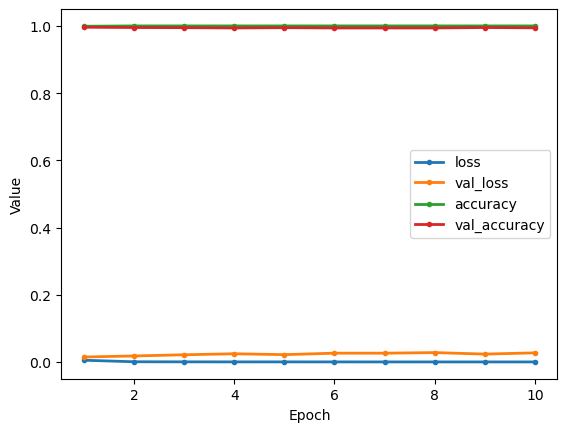

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/91 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step

 5/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  

 9/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

13/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

17/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

21/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

25/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

29/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

33/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

37/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

41/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

45/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

49/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

53/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

57/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

61/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

65/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 1/91 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step

 5/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  

 9/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

13/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

17/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

21/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

25/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

29/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

33/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

37/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

42/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

46/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

50/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

54/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

58/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

62/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

66/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/LBD/report_0QBJS3OT.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################